# Tutorial 1 - RNN Sequence classifier

In this notebook, we will predict the winner of a basketball game based on the scores observed in the first 3 quarters of the game. Each column represents the beginning of a minute during the game. (There are 12 minutes in each quarter. There are  3 quarters in the data, so we have 36 columns as input variables in chronological order.) The values captured in each column represent the score difference observed at that minute (home score minus away score)<br><br>

The last column `W` represents whether the home team (1) or the away team (0) won the game. This is the target variable. <br><br>
**Our unit of analysis is a single game.**

In [1]:
# Common imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

epoch_num = 5 # numer of epochs to train each model

## Load and split data

Basketball data consists of each row (observation) representing a single game. The first 36 columns represent the score difference at each minute of the game. The last column represents the winner of the game (1 = home team, 0 = away team). The data is stored in a csv file. We will load the data into a pandas dataframe.

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/prof-tcsmith/data/master/basketball.csv")

We see that we have 1230 observations (games) and 37 columns (36 minutes of the game + 1 target variable).  

In [3]:
data.shape

(1230, 37)

In [4]:
data.head(5)

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,...,M28,M29,M30,M31,M32,M33,M34,M35,M36,W
0,-2,-1,1,1,-1,-3,-1,0,3,6,...,9,11,10,7,7,4,6,2,1,1
1,0,2,7,6,10,8,8,6,0,6,...,7,11,11,14,14,15,13,13,13,0
2,0,-2,2,0,5,4,5,3,5,3,...,9,11,13,13,12,17,15,15,12,1
3,0,2,0,3,4,3,5,4,3,1,...,10,6,7,7,8,8,8,8,8,1
4,0,-2,-2,0,3,-2,-7,-5,-7,-4,...,10,10,15,13,11,11,11,13,10,1


Split each observation into a sequence of 36 observations (minutes) and a single observation (winner). The sequence of 36 observations will be the input (X) to the RNN. The single observation (y) will be the target variable.

In [5]:
y = data['W']
X = data.drop('W', axis=1)

In [6]:
y = np.array(y).astype(np.int8) 
X = np.array(X).astype(np.int8)

Finally, we need to split the data into training and test sets. A random split on this data is OK, as each 'game' (observation) is independent of the others. We will use 70% of the data for training and 30% for testing.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Create dataframe to store results    

We are running 8 models in this notebook. We will store the results in a dataframe for easy comparison.

In [8]:
df_results = pd.DataFrame({'model': [], 'time': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []})

## MODEL01 - A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [9]:
print(X_train.shape)  # 2d array of shape (n_samples, n_features)
print(y_train.shape)  # 1d array of shape (n_samples,)

(861, 36)
(861,)


In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[36, 1]),
    keras.layers.Dense(72, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  
])

/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-04-09 07:30:26.758631: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-09 07:30:26.758655: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-09 07:30:26.758662: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-09 07:30:26.758680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 07:30:26.758694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/jo

In [11]:
model.compile(
    loss="binary_crossentropy",  # If multiclass, use "sparse_categorical_crossentropy" as the loss function
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 72)             │         2,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,737 (10.69 KB)

 Trainable params: 2,737 (10.69 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
### How to interpret the output shape?

* The first layer
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * 36 is the number of units in the layer, since there will be 36 outputs from this layer 36, the second dimension will have 36
* The second layer
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network. This will be the same at each later, since the batch size is the same during each epoch.
  * 72 is the number of units in the layer, since there will be 72 outputs from these 72 units
* The third layer
  * None is a wild-card, is the number of observations given in the batch.
  * 1 is the number of units in the layer. Since the output is a binary value, there is one unit for the output, and therefore 1 is the number of outputs.


We can write this formulaically as:

In [13]:
p = 1  # for NN, one weight per unit input
b = 1  # for NN, one bias per unit

# First hidden layer
i = 36 # 36 inputs from the previous layer (flatten layer)
h = 72 # number of units in this layer 

p * (h*i + b*h)

2664

### Calculate the number of paramaters for the model

* The first later doesn't have any parameters, because it's just flattening the input
    * 0 inputs to 36 unites, is 0 weights and zero biases
* The second layer has 36 units connecting to 72 units, so 36**72 weights. If each weight also has a bias, then we add 72
    * 36*72+72 = 2664
* The third layer has 72 outputs from the previous later to 1 unit, so 72 weights. If each unit in the layer has a bias, then we add 1 since there is only one unit
    * 72+1=73

https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889

In [14]:
import time
start_time = time.time()

call_back = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test),
    callbacks=[call_back]
)

end_time = time.time()

Epoch 1/5


2024-04-09 07:30:27.617055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5047 - loss: 2.9070 - val_accuracy: 0.7371 - val_loss: 0.6694
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7198 - loss: 0.7530 - val_accuracy: 0.7805 - val_loss: 0.5617
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7477 - loss: 0.6374 - val_accuracy: 0.7805 - val_loss: 0.5219
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7589 - loss: 0.5625 - val_accuracy: 0.7751 - val_loss: 0.5007
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7667 - loss: 0.5233 - val_accuracy: 0.7940 - val_loss: 0.4889


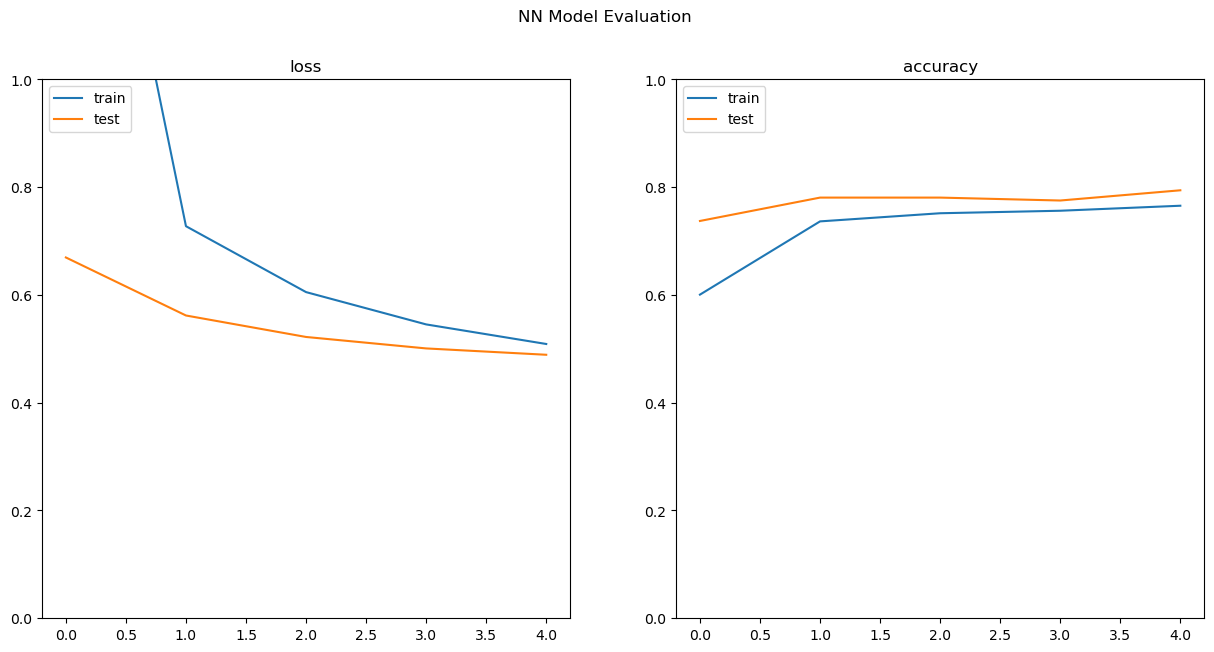

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('NN Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [16]:
y_pred = model.predict(X_test)
y_pred[:10]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[1.2957262e-01],
       [8.8312477e-01],
       [2.1697335e-01],
       [6.0153572e-04],
       [2.4946399e-01],
       [5.0688112e-01],
       [3.8714585e-01],
       [9.5346004e-01],
       [2.1333496e-01],
       [9.5856142e-01]], dtype=float32)

In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5).astype('int8') # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0     0.7407    0.8383    0.7865       167
           1     0.8500    0.7574    0.8010       202

    accuracy                         0.7940       369
   macro avg     0.7954    0.7979    0.7938       369
weighted avg     0.8006    0.7940    0.7945       369



Store the results into the results dataframe.

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['NN'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## Transform data for RNN

RNN requires input of three dimensions:
* The first dimension is the number of observations (games). 
* The second dimension is the number of time steps (minutes). 
* The third dimension is the number of features (in this case, 1, which is the score difference). 
  
Our input variable (X) is a sequence of 36 observations. We will use the `reshape` method to reshape the data into a 3D array. The `reshape` method will return a 3D array with the shape (861, 36, 1) for the training data and (369, 36, 1) for the test data.

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(861, 36, 1)
(369, 36, 1)


## MODEL02 - Simple RNN with one layer

In [20]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(40, input_shape=[n_steps, n_inputs]),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)
model.summary()

/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 40)             │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721 (6.72 KB)

 Trainable params: 1,721 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

### How to interpret the output shape.

* First layer:
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * There are 32 RNN units and each produces one output. Therefore, 32 is the output shape.
* In the second layer, there is one unit and it produces one output. Therefore, 1 * 1 = 1

### Calculate the number of paramaters for the model

In [21]:
p = 1 # number of parameters per unit (for RNN one remember gate)
b = 1 # number of biases per unit, for RNN this is 1 (for GRU this is 3, and LSTM this is 4)

##################################
# For first layer....

h = 40 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the last layer

# This is simply 40 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 40+1)

First layer params =  1680
Last layer params =  41


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)

In [23]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 400ms/step - accuracy: 0.2857 - loss: 0.9109 - val_accuracy: 0.8157 - val_loss: 0.5214
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 516ms/step - accuracy: 0.7808 - loss: 0.5321 - val_accuracy: 0.8103 - val_loss: 0.4215
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 596ms/step - accuracy: 0.8074 - loss: 0.4473 - val_accuracy: 0.8184 - val_loss: 0.4052
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 557ms/step - accuracy: 0.8231 - loss: 0.4224 - val_accuracy: 0.8049 - val_loss: 0.3975
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 585ms/step - accuracy: 0.8188 - loss: 0.4115 - val_accuracy: 0.8076 - val_loss: 0.3946


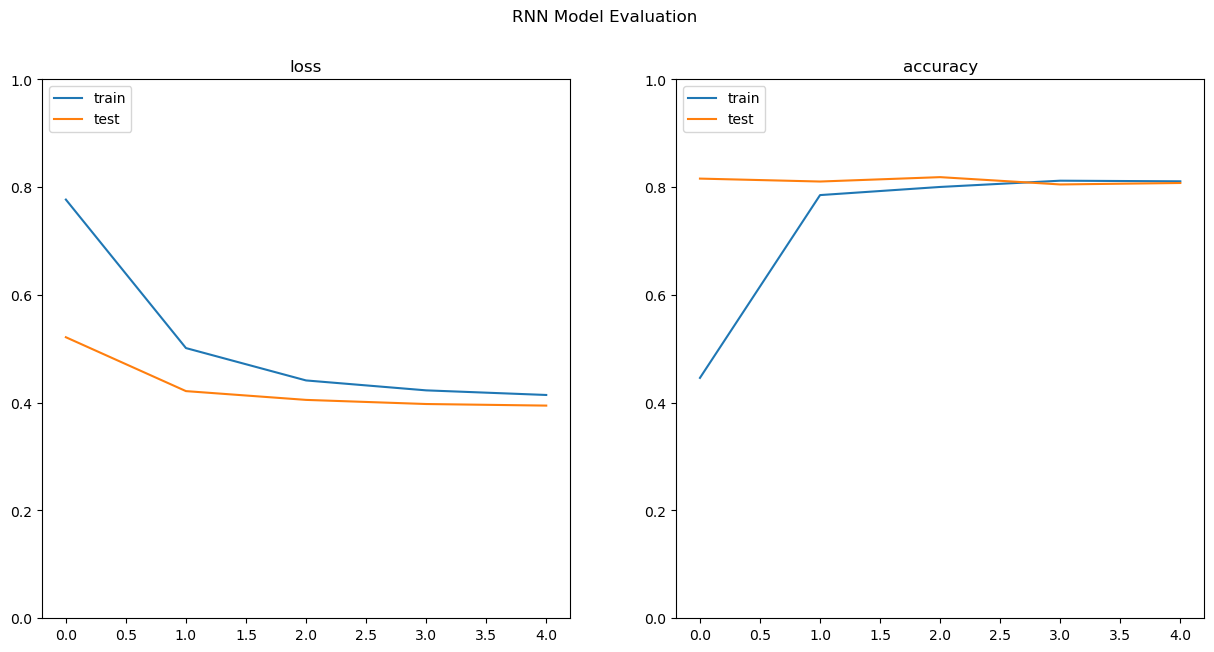

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [25]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
              precision    recall  f1-score   support

           0     0.8158    0.7425    0.7774       167
           1     0.8018    0.8614    0.8305       202

    accuracy                         0.8076       369
   macro avg     0.8088    0.8020    0.8040       369
weighted avg     0.8082    0.8076    0.8065       369



In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['RNN'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## MODEL03 - Deep RNN

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training.**

**Since the last layer is DENSE, it can't take sequence data. Therefore, you CANNOT return sequences from the previous layer. So, remove** `return_sequences` **from previous layer.**

In [27]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
        keras.layers.SimpleRNN(16, return_sequences=True),
        keras.layers.SimpleRNN(32, return_sequences=False), 
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 36, 32)         │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 36, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,473 (13.57 KB)

 Trainable params: 3,473 (13.57 KB)

 Non-trainable params: 0 (0.00 B)

### How to  intepret the output shape?

* First layer:
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * There are 36 features (which are the 'time steps' of values in the sequence), and there are 32 RNN units.
    * (batch size, time steps, features) = (None, 36, 32)
* etc. (see previous models where I elaborate on the output shape - writing this is getting repetitive)

### Calculate the number of paramaters for the model

In [29]:
p = 1 # number of parameters per unit (for RNN one remember gate)
b = 1 # number of biases per unit, for RNN this is 1 (for GRU this is 3, and LSTM this is 4)

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For second layer....

h = 16 # number of units in the layer
i = 32  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("Second layer params = ", params)

##################################
# For third layer....

h = 32 # number of units in the layer
i = 16  # number of inputs (previous layer has 16 inutes, so we have 16 inputs)

params = p*(h**2+i*h+b*h)
print("Third layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  1088
Second layer params =  784
Third layer params =  1568
Last layer params =  33


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

# If multiclass, use "sparse_categorical_crossentropy" as the loss function
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)

In [31]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose=1, mode='auto')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data = (X_test, y_test), 
    callbacks=[early_stop]
)  

end_time = time.time()

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7556 - loss: 0.5134 - val_accuracy: 0.8211 - val_loss: 0.4012
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.8024 - loss: 0.4187 - val_accuracy: 0.8211 - val_loss: 0.3957
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8055 - loss: 0.4055 - val_accuracy: 0.8184 - val_loss: 0.3937
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8116 - loss: 0.3973 - val_accuracy: 0.8157 - val_loss: 0.3933
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.8119 - loss: 0.3909 - val_accuracy: 0.8157 - val_loss: 0.3930


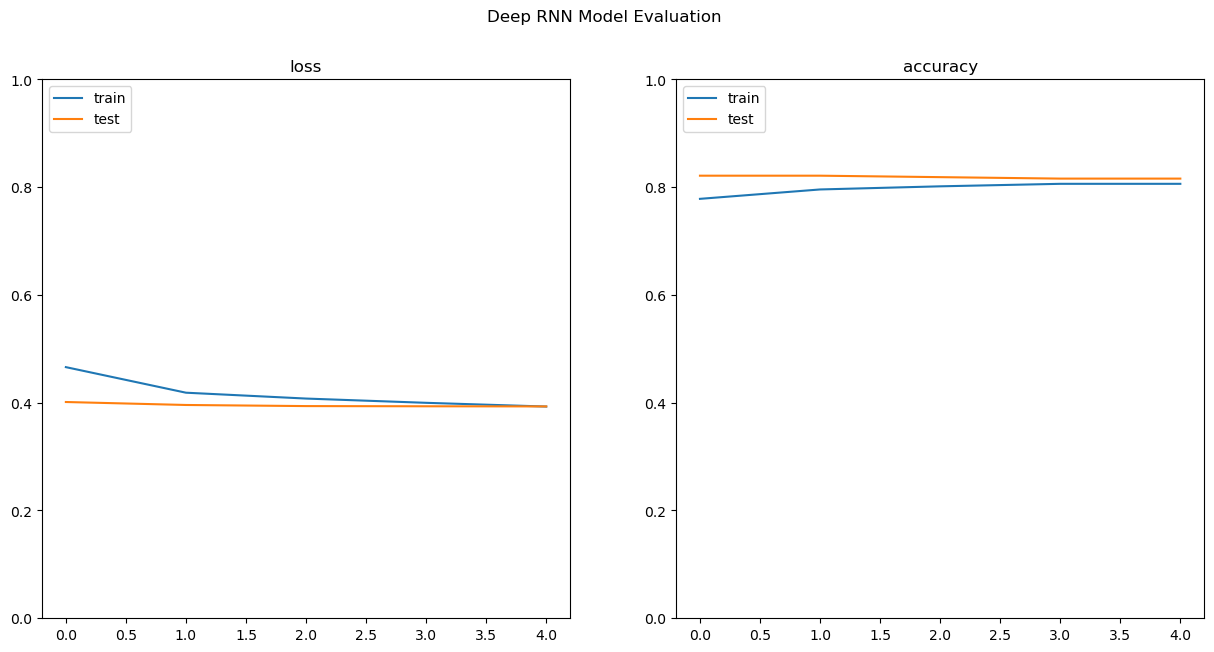

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Deep RNN Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [33]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step
              precision    recall  f1-score   support

           0     0.8113    0.7725    0.7914       167
           1     0.8190    0.8515    0.8350       202

    accuracy                         0.8157       369
   macro avg     0.8152    0.8120    0.8132       369
weighted avg     0.8156    0.8157    0.8152       369



In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep RNN'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## MODEL04 - LSTM with one layer

In [35]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential(
    [
        keras.layers.LSTM(32, input_shape=[n_steps, n_inputs]),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

### Calculate the number of paramaters for the model

In [37]:
p = 4 # number of parameters per unit (for LSTM: 1 forget gate, 2 input gates, and 1 output gate)
b = 1 # number of biases per unit, for LSTM this is 1

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  4352
Last layer params =  33


In [38]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
) 

end_time = time.time()

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4131 - loss: 0.7229 - val_accuracy: 0.8103 - val_loss: 0.5309
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7732 - loss: 0.5184 - val_accuracy: 0.8320 - val_loss: 0.4410
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7906 - loss: 0.4602 - val_accuracy: 0.8293 - val_loss: 0.4148
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8086 - loss: 0.4378 - val_accuracy: 0.8320 - val_loss: 0.4026
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8094 - loss: 0.4276 - val_accuracy: 0.8293 - val_loss: 0.3988


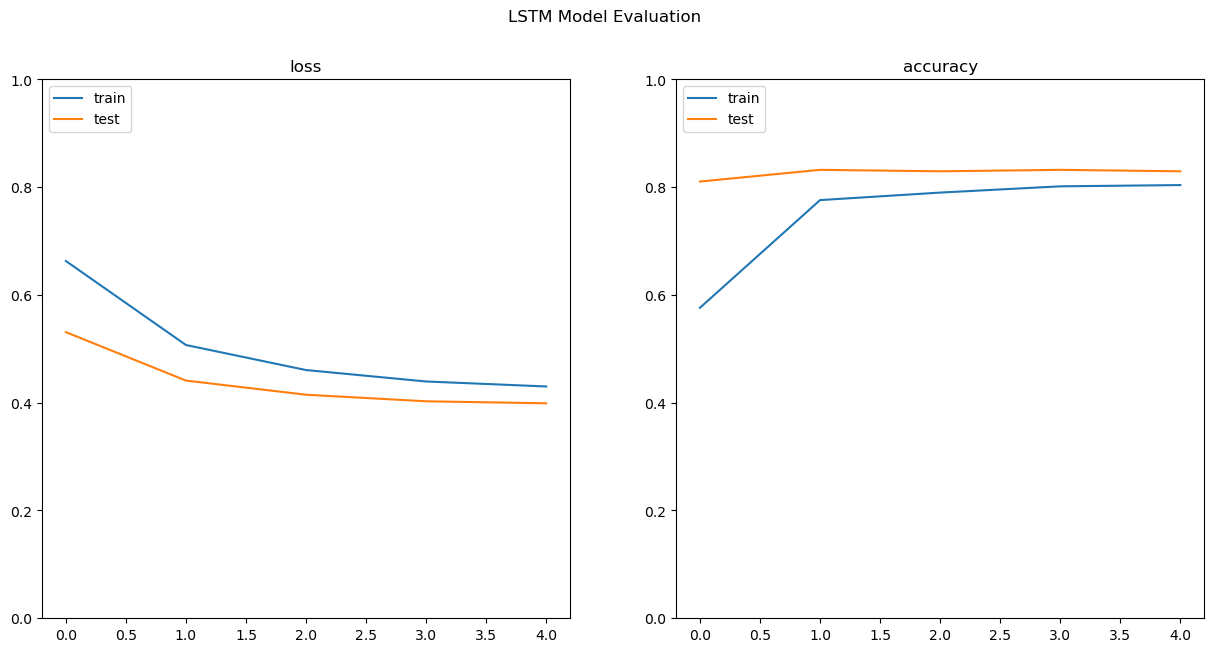

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('LSTM Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [40]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
              precision    recall  f1-score   support

           0     0.8210    0.7964    0.8085       167
           1     0.8357    0.8564    0.8460       202

    accuracy                         0.8293       369
   macro avg     0.8284    0.8264    0.8272       369
weighted avg     0.8291    0.8293    0.8290       369



In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['LSTM'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## MODEL05 - LSTM with more layers

In [42]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')
])

/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 36, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 36, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

### Calculate the number of paramaters for the model

In [44]:
# Everything is the same as calculating the RNN, except for p
p = 4 # number of parameters per unit (for LSTM - 1 forget gate, 2 input gates, and 1 output gate)
b = 1 # number of biases per unit, for LSTM this is 1

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the second layer

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 incoming inputs)

params = p*(h**2+i*h+b*h)
print("Second layer params = ", params)

##################################
# for the third layer

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 incoming inputs)

params = p*(h**2+i*h+b*h)
print("Third layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  4352
Second layer params =  8320
Third layer params =  8320
Last layer params =  33


In [45]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] # we defined this early_stop callback function earlier
)

end_time = time.time()

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.7008 - loss: 0.6011 - val_accuracy: 0.7724 - val_loss: 0.4792
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7459 - loss: 0.5042 - val_accuracy: 0.7995 - val_loss: 0.4370
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7561 - loss: 0.4732 - val_accuracy: 0.8211 - val_loss: 0.4217
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7630 - loss: 0.4568 - val_accuracy: 0.8184 - val_loss: 0.4151
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7813 - loss: 0.4445 - val_accuracy: 0.8184 - val_loss: 0.4112


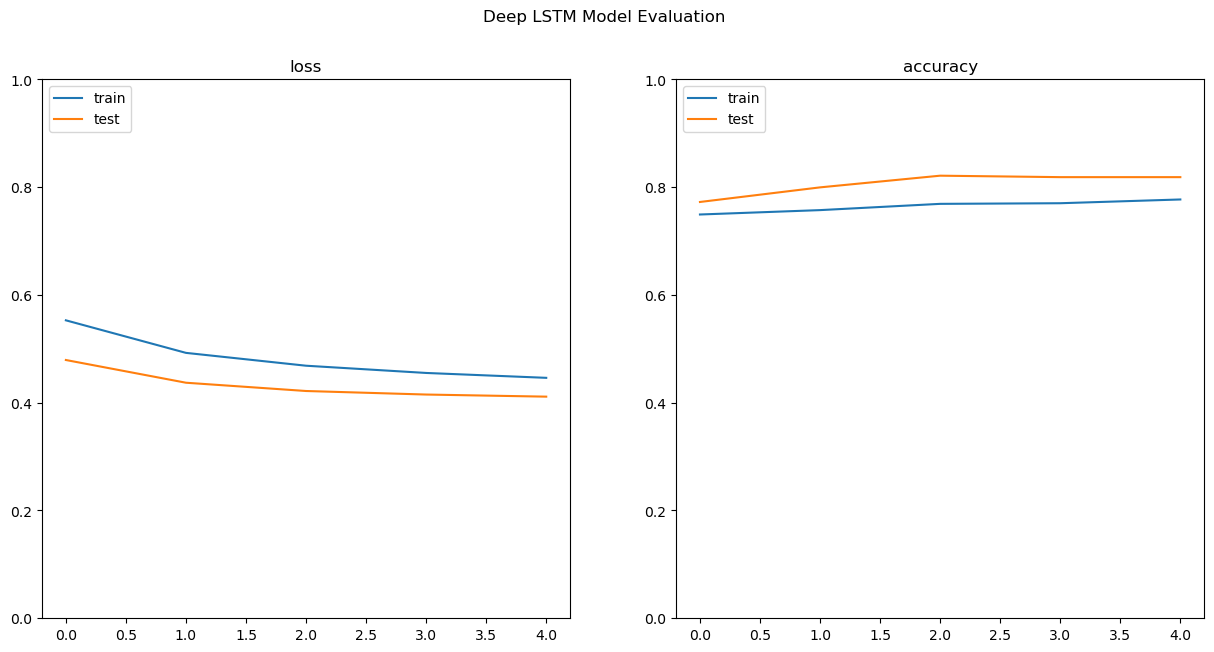

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Deep LSTM Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [47]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
              precision    recall  f1-score   support

           0     0.8425    0.7365    0.7859       167
           1     0.8027    0.8861    0.8424       202

    accuracy                         0.8184       369
   macro avg     0.8226    0.8113    0.8141       369
weighted avg     0.8207    0.8184    0.8168       369



In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep LSTM'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## MODEL06 - GRU with one layer

In [49]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.GRU(32, input_shape=[n_steps, n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')
])

/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

### Calculate the number of paramaters for the model

In [51]:
# Everything is the same as calculating the RNN or LSTM parameters, except for p
p = 3 # number of parameters per unit (for GRU - 1 forget gate, 1 input gates, and 1 output gate)
b = 2 # number of biases per unit, for GRU this is 2

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  3360
Last layer params =  33


In [52]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test),
    callbacks=[early_stop] # we defined this early_stop callback function earlier
)

end_time = time.time()

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7795 - loss: 0.4419 - val_accuracy: 0.8266 - val_loss: 0.3876
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7829 - loss: 0.4220 - val_accuracy: 0.8184 - val_loss: 0.3853
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7908 - loss: 0.4133 - val_accuracy: 0.8130 - val_loss: 0.3851
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7955 - loss: 0.4095 - val_accuracy: 0.8184 - val_loss: 0.3848
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7946 - loss: 0.4074 - val_accuracy: 0.8211 - val_loss: 0.3845


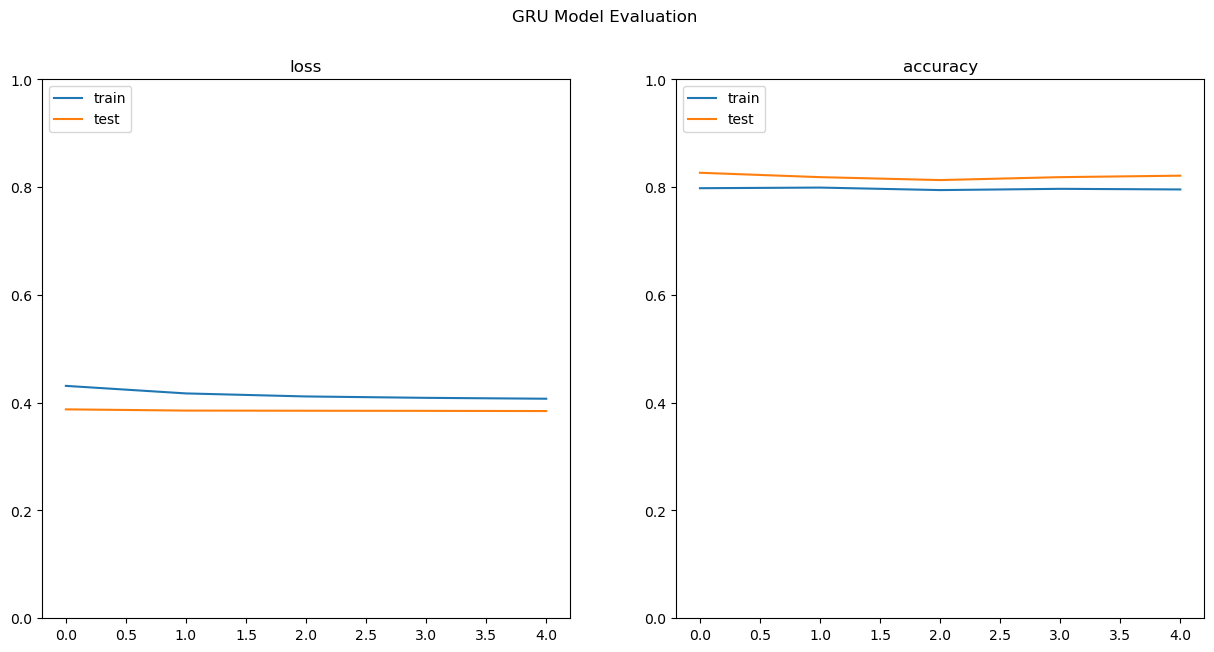

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [54]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0     0.8176    0.7784    0.7975       167
           1     0.8238    0.8564    0.8398       202

    accuracy                         0.8211       369
   macro avg     0.8207    0.8174    0.8187       369
weighted avg     0.8210    0.8211    0.8207       369



In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['GRU'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## MODEL07 - GRU with more layers

In [56]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.GRU(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.GRU(32, return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(1, activation='sigmoid')
])

/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 36, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 36, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,065 (62.75 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 0 (0.00 B)

### Calculate the number of paramaters for the model

In [58]:
# Everything is the same as calculating the RNN or LSTM parameters, except for p
p = 3 # number of parameters per unit (for GRU - 1 forget gate, 1 input gates, and 1 output gate)
b = 2 # number of biases per unit, for GRU this is 2

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For second layer....

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 inputs)

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For third layer....

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 inputs)

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  3360
First layer params =  6336
First layer params =  6336
Last layer params =  33


In [59]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] 
)

end_time = time.time()

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5762 - loss: 0.6405 - val_accuracy: 0.8320 - val_loss: 0.4160
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7628 - loss: 0.4734 - val_accuracy: 0.8293 - val_loss: 0.4025
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7727 - loss: 0.4435 - val_accuracy: 0.8347 - val_loss: 0.3909
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7716 - loss: 0.4266 - val_accuracy: 0.8320 - val_loss: 0.3868
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7776 - loss: 0.4176 - val_accuracy: 0.8238 - val_loss: 0.3840


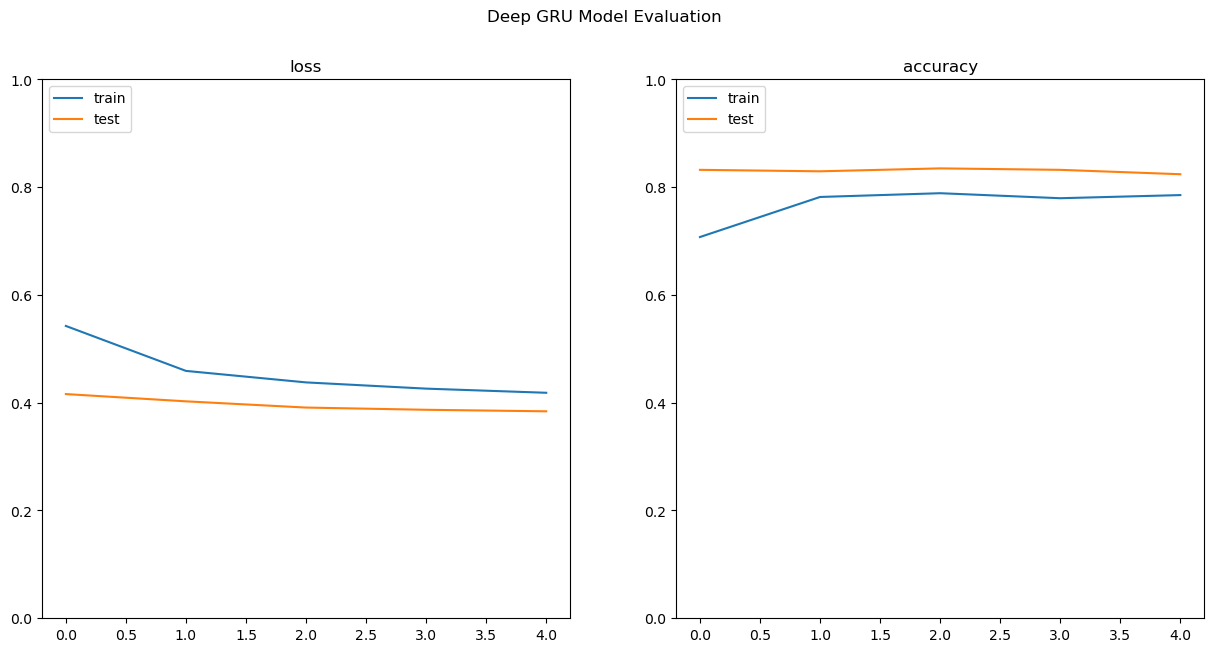

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Deep GRU Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [61]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
              precision    recall  f1-score   support

           0     0.8228    0.7784    0.8000       167
           1     0.8246    0.8614    0.8426       202

    accuracy                         0.8238       369
   macro avg     0.8237    0.8199    0.8213       369
weighted avg     0.8238    0.8238    0.8233       369



In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep GRU'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## MODEL08 - LSTM with Conv1D

In [63]:
n_steps = 36
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=10, kernel_size=3, strides=1, padding="valid", input_shape=[n_steps, n_inputs]),
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid"),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/Users/timsmith/miniconda3/envs/dsp/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 34, 10)         │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 20)         │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32, 32)         │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,797 (61.71 KB)

 Trainable params: 15,797 (61.71 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.010), 
    metrics=['accuracy']
)

In [65]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] 
)

end_time = time.time()

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7545 - loss: 0.5260 - val_accuracy: 0.8157 - val_loss: 0.3957
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7831 - loss: 0.4275 - val_accuracy: 0.8103 - val_loss: 0.3928
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7988 - loss: 0.4136 - val_accuracy: 0.8184 - val_loss: 0.3947
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8078 - loss: 0.4101 - val_accuracy: 0.8238 - val_loss: 0.4010
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8257 - loss: 0.4012 - val_accuracy: 0.8184 - val_loss: 0.4084


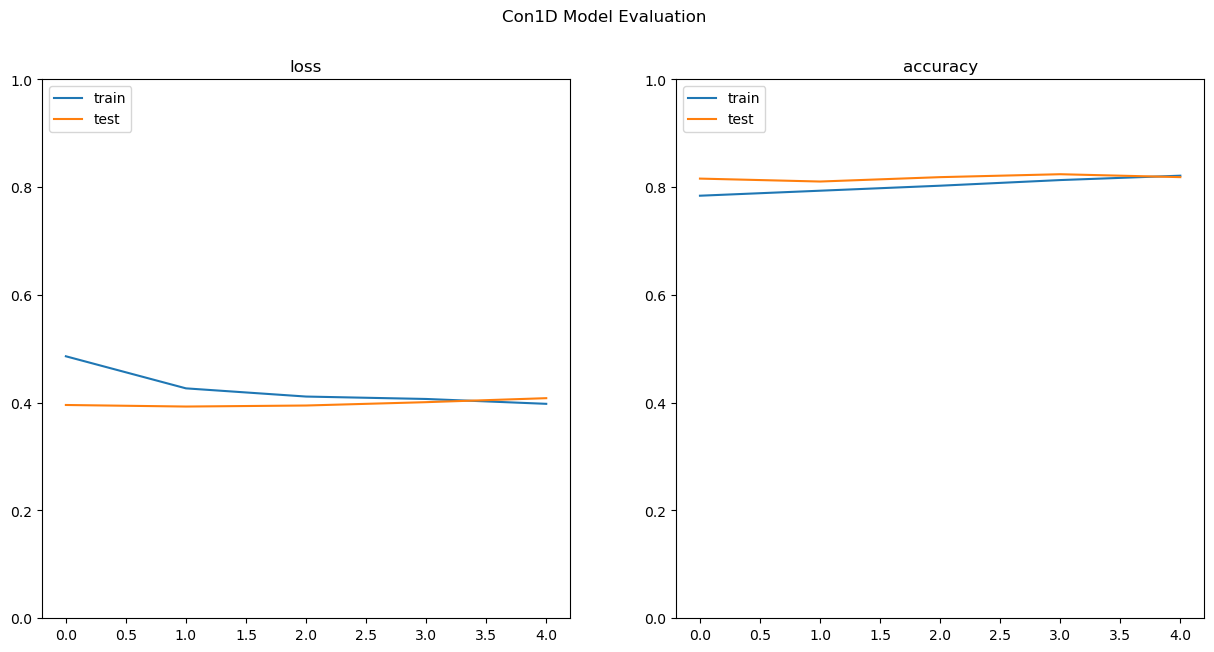

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Con1D Model Evaluation')

ax1.set_title('loss')
ax1.set_ylim(0, 1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('accuracy')
ax2.set_ylim(0, 1)
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [67]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function
y_pred = (y_pred > 0.5) # let's turn these into predictions (0 or 1)

print(classification_report(y_test, y_pred, digits=4))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
              precision    recall  f1-score   support

           0     0.8205    0.7665    0.7926       167
           1     0.8169    0.8614    0.8386       202

    accuracy                         0.8184       369
   macro avg     0.8187    0.8139    0.8156       369
weighted avg     0.8185    0.8184    0.8177       369



In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Conv1D Deep LSTM'], 
        'time': [end_time - start_time],
        'accuracy': [accuracy_score(y_test, y_pred)], 
        'precision': [precision_score(y_test, y_pred)], 
        'recall': [recall_score(y_test, y_pred)], 
        'f1': [f1_score(y_test, y_pred)]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## Summary of results

In [69]:
df_results.sort_values(by=['accuracy', 'precision', 'recall', 'f1'], ascending=False)

,model,time,accuracy,precision,recall,f1
3,LSTM,5.880496,0.829268,0.835749,0.856436,0.845966
6,Deep GRU,10.679676,0.823848,0.824645,0.861386,0.842615
5,GRU,5.929280,0.821138,0.823810,0.856436,0.839806
7,Conv1D Deep LSTM,12.128046,0.818428,0.816901,0.861386,0.838554
4,Deep LSTM,11.437630,0.818428,0.802691,0.886139,0.842353
2,Deep RNN,367.517398,0.815718,0.819048,0.851485,0.834951
1,RNN,72.692728,0.807588,0.801843,0.861386,0.830549
0,NN,3.624414,0.794038,0.850000,0.757426,0.801047
